CPH 02/04/2022

# MOCCA data analysis on Knoevenagel case study

MOCCA is a tool for the analysis of *High-Performance Liquid Chromatography–Diode Array Detection* (HPLC–DAD) datasets which are recorded in the context of reaction (process) controls. It only uses HPLC–DAD raw data and some basic user input for the data analysis.

## Reaction and case study background

This case study was designed to verify that we get the same results when we are analyzing non-overlapping data manually compared to when we are using MOCCA. We perform four different Knoevenagel condensations in four HPLC vials directly in the autosampler of an Agilent LC system. For that, we use four different benzaldehydes (benzaldehyde, 4-chlorobenzaldehyde, 4-methoxybenzaldehyde, 4-dimethylaminobenzaldehyde) and malononitrile as substrates and piperidine as basic catalyst.

To highlight MOCCA's decomposition capabilities of impure peaks, we compare the obtained results of the single reactions with results we recorded for a reaction mixture of all four single reactions (1:1:1:1).

## Imports

In [1]:
# folders handling
import os
from glob import glob

# user interaction
from mocca.user_interaction.campaign import HplcDadCampaign
from mocca.user_interaction.user_objects import Gradient
from mocca.user_interaction.user_objects import Compound
from mocca.user_interaction.user_objects import InternalStandard
from mocca.user_interaction.user_objects import HplcInput
from mocca.user_interaction.settings import Settings

# reporting
from mocca.report.hplc_input import report_hplc_input
from mocca.report.chroms import report_chroms
from mocca.report.results import report_runs
from mocca.report.parafac import report_parafac
from mocca.report.peaks import report_peaks
from mocca.report.quali_comps import report_quali_comps
from mocca.report.quant_comps import report_quant_comps

# customized data analysis
import datetime
import time

%load_ext autoreload
%autoreload 2

## Knoevenagel data folder handling

The data corresponding to this notebook can be found in mocca -> notebooks -> knoevenagel_data. The data was recorded on an Agilent system on two different days. Therefore, we have two different gradient runs.

In [2]:
# get path of this notebook
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

# add the path to the test data folder
knoev_data_path = os.path.join(ipynb_path, "knoevenagel_data")

# find all folders containing Agilent HPLC data (.D file extension)
folders = glob(knoev_data_path + '/*' + '.D') 
folders = sorted(folders)

In [3]:
for folder in folders:
    print(os.path.basename(folder))

2022-01-26_19-43-27_gradient.D
2022-01-26_19-48-52_ba_1.D
2022-01-26_19-54-51_ba_0.75.D
2022-01-26_20-00-51_ba_0.5.D
2022-01-26_20-06-51_ba_0,25.D
2022-01-26_20-12-55_cl_1.D
2022-01-26_20-18-55_cl_0.75.D
2022-01-26_20-24-53_cl_0.5.D
2022-01-26_20-30-51_cl_0,25.D
2022-01-26_20-36-52_ome_1.D
2022-01-26_20-43-08_ome_0.75.D
2022-01-26_20-49-05_ome_0.5.D
2022-01-26_20-55-06_ome_0,25.D
2022-01-26_21-01-10_nme2_1.D
2022-01-26_21-07-11_nme2_0.75.D
2022-01-26_21-13-09_nme2_0.5.D
2022-01-26_21-19-09_nme2_0,25.D
2022-01-28_11-27-26_gradient.D
2022-01-28_11-35-44_ba.D
2022-01-28_11-41-59_cl.D
2022-01-28_11-48-11_ome.D
2022-01-28_11-54-24_nme2.D
2022-01-28_12-00-35_mix.D
2022-01-28_12-15-41_ba.D
2022-01-28_12-21-55_cl.D
2022-01-28_12-28-04_ome.D
2022-01-28_12-34-15_nme2.D
2022-01-28_12-40-25_mix.D
2022-01-28_12-55-36_ba.D
2022-01-28_13-01-48_cl.D
2022-01-28_13-07-56_ome.D
2022-01-28_13-14-06_nme2.D
2022-01-28_13-20-16_mix.D
2022-01-28_13-35-23_ba.D
2022-01-28_13-41-37_cl.D
2022-01-28_13-47-47_ome.D

## Campaign initialization

In [4]:
knoev_campaign = HplcDadCampaign()

### User input for calibration runs

We transfer the concentration values of the calibration standards.

In [5]:
ba_concs = [0.965, 0.761, 0.482, 0.231]
cl_concs = [1.01, 0.744, 0.478, 0.234]
ome_concs = [0.990, 0.723, 0.455, 0.231]
nme2_concs = [0.982, 0.719, 0.468, 0.229]

We create the first Gradient object for all calibration runs.

In [6]:
gradient_calib = Gradient(folders[0])

We create HplcInput objects for each calibration run and add it to the campaign

In [7]:
for i, folder in enumerate(folders[1:5]):
    compound = Compound('benzaldehyde', ba_concs[i])
    exp = HplcInput(folder, gradient_calib, compound=compound)
    knoev_campaign.add_hplc_input(exp)

for i, folder in enumerate(folders[5:9]):
    compound = Compound('4-chlorobenzaldehyde', cl_concs[i])
    exp = HplcInput(folder, gradient_calib, compound=compound)
    knoev_campaign.add_hplc_input(exp)

for i, folder in enumerate(folders[9:13]):
    compound = Compound('4-methoxybenzaldehyde', ome_concs[i])
    exp = HplcInput(folder, gradient_calib, compound=compound)
    knoev_campaign.add_hplc_input(exp)

for i, folder in enumerate(folders[13:17]):
    compound = Compound('4-dimethylaminobenzaldehyde', nme2_concs[i])
    exp = HplcInput(folder, gradient_calib, compound=compound)
    knoev_campaign.add_hplc_input(exp)

### User input for reaction runs

First, we generate the Gradient object of the second day.

In [8]:
gradient_react = Gradient(folders[17])

Then, we generate HplcInput objects for all reaction runs and add them to the campaign.

In [9]:
for folder in folders[18:]:
    exp = HplcInput(folder, gradient_react)
    knoev_campaign.add_hplc_input(exp)

### Settings for data processing

In [10]:
settings = Settings('chemstation',
                    absorbance_threshold = 300, wl_high_pass = 215, 
                    peaks_high_pass = 1, peaks_low_pass = 3.2,
                    spectrum_correl_thresh=0.99, relative_distance_thresh=0.01)

### Data processing

In [11]:
knoev_campaign.process_all_hplc_input(settings)

0.9994126922588047
0.9994126922588047
0.9994126922588047
0.9995920530215695
0.9995920530215695
0.9995920530215695
0.6844631771373247
0.9025990466737809
0.9999492666961827
0.684463177137324
0.90259904667378
0.9999492666961816
0.6844631771373241
0.90259904667378
0.9999492666961816
0.6844631771373241
0.90259904667378
0.9999492666961816
0.6844631771373244
0.9025990466737805
0.9999492666961821
0.6844631771373241
0.90259904667378
0.9999492666961816
0.6844631771373236
0.9025990466737798
0.9999492666961814
0.6844631771373241
0.9025990466737802
0.9999492666961819
0.9996833955367187
0.9996833955367187
0.9996833955367187
0.9939076375325376
0.9999033377303408
0.9939076375325376
0.9999033377303408
0.9939076375325376
0.9999033377303408
0.9939076375325376
0.9999033377303408
0.9939076375325376
0.9999033377303408
0.9939076375325376
0.9999033377303408
0.9978913979167573
0.9998541745821748
0.9978913979167573
0.9998541745821748
0.9978913979167573
0.9998541745821748
0.6849775274877418
0.9028662493369838
0.

## Reporting

In [12]:
knoev_report_path = os.path.join(ipynb_path, "knoevenagel_reports")

In [13]:
report_hplc_input(knoev_campaign.hplc_runs, knoev_report_path)
report_chroms(knoev_campaign.chroms, knoev_campaign.settings, knoev_report_path)
report_runs(knoev_campaign.chroms, knoev_campaign.quali_comp_db, knoev_campaign.quant_comp_db, knoev_report_path)
report_parafac(knoev_campaign.chroms, knoev_report_path)
report_peaks(knoev_campaign.peak_db, knoev_report_path)
report_quali_comps(knoev_campaign.quali_comp_db, knoev_report_path)
report_quant_comps(knoev_campaign.quant_comp_db, knoev_report_path)

Report saved to .//Users/haascp/Documents/GitHub/mocca/notebooks/knoevenagel_reports/report_hplc_input.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/notebooks/knoevenagel_reports/report_chroms.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/notebooks/knoevenagel_reports/report_runs.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/notebooks/knoevenagel_reports/report_parafac.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/notebooks/knoevenagel_reports/report_peak_db.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/notebooks/knoevenagel_reports/report_quali_comp_db.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Report saved to .//Users/haascp/Documents/GitHub/mocca/notebooks/knoevenagel_reports/report_quant_comp_db.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

## Customized data analysis by the user

This data analysis tool cannot include all possible data analysis needs of potential users. Therefore, we expect the user to do customized data analysis independently from the tool.

We give an example here, how a reaction kinetics data analysis could look like. First, we have to determine reaction times. For that, we noted the times, when we added all components together in the HPLC vial and use the time stamps in the folder names to calculate the reaction times.

In [14]:
def timestamp(path):
    x = os.path.basename(path)
    date, times = x[:x.rfind('_')].split('_')
    date = list(map(int, date.split('-')))
    times = list(map(int, times.split('-')))
    return time.mktime(datetime.datetime(date[0], date[1], date[2], times[0], times[1], times[2]).timetuple())

In [15]:
# start times
ba_time = time.mktime(datetime.datetime(2022, 1, 28, 11, 24, 30).timetuple())
cl_time = time.mktime(datetime.datetime(2022, 1, 28, 11, 26, 30).timetuple())
ome_time = time.mktime(datetime.datetime(2022, 1, 28, 11, 27, 30).timetuple())
nme2_time = time.mktime(datetime.datetime(2022, 1, 28, 11, 29, 30).timetuple())
mix_time = time.mktime(datetime.datetime(2022, 1, 28, 11, 33, 30).timetuple())

In [20]:
ba_reaction = []  # list of time, conc tuples
cl_reaction = []  # list of time, conc tuples
ome_reaction = []  # list of time, conc tuples
nme2_reaction = []  # list of time, conc tuples
ba_mix = []  # list of time, conc tuples
cl_mix = []  # list of time, conc tuples
ome_mix = []  # list of time, conc tuples
nme2_mix = []  # list of time, conc tuples

react_chroms = [chrom for chrom in knoev_campaign.chroms if not chrom.experiment.compound]
for chrom in react_chroms:
    if "_ba" in chrom.experiment.path:
        t = timestamp(chrom.experiment.path) - ba_time
        if "benzaldehyde" in chrom:
            ba_reaction.append((t, chrom["benzaldehyde"].concentration))
        else:
            ba_reaction.append((t, 0))
    if "_cl" in chrom.experiment.path:
        t = timestamp(chrom.experiment.path) - cl_time
        if "4-chlorobenzaldehyde" in chrom:
            cl_reaction.append((t, chrom["4-chlorobenzaldehyde"].concentration))
        else:
            cl_reaction.append((t, 0))
    if "_ome" in chrom.experiment.path:
        t = timestamp(chrom.experiment.path) - ome_time
        if "4-methoxybenzaldehyde" in chrom:
            ome_reaction.append((t, chrom["4-methoxybenzaldehyde"].concentration))
        else:
            ome_reaction.append((t, 0))
    if "_nme2" in chrom.experiment.path:
        t = timestamp(chrom.experiment.path) - nme2_time
        if "4-dimethylaminobenzaldehyde" in chrom:
            nme2_reaction.append((t, chrom["4-dimethylaminobenzaldehyde"].concentration))
        else:
            nme2_reaction.append((t, 0))
    if "_mix" in chrom.experiment.path:
        t = timestamp(chrom.experiment.path) - mix_time
        if "benzaldehyde" in chrom:
            ba_mix.append((t, chrom["benzaldehyde"].concentration))
        else:
            ba_mix.append((t, 0))
        if "4-chlorobenzaldehyde" in chrom:
            cl_mix.append((t, chrom["4-chlorobenzaldehyde"].concentration))
        else:
            cl_mix.append((t, 0))
        if "4-methoxybenzaldehyde" in chrom:
            ome_mix.append((t, chrom["4-methoxybenzaldehyde"].concentration))
        else:
            ome_mix.append((t, 0))
        if "4-dimethylaminobenzaldehyde" in chrom:
            nme2_mix.append((t, chrom["4-dimethylaminobenzaldehyde"].concentration))
        else:
            nme2_mix.append((t, 0))
    

In [23]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

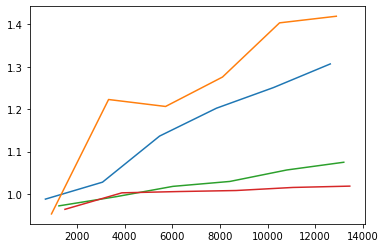

In [31]:
plt.plot(list(zip(*ba_reaction))[0], [1 / i for i in list(zip(*ba_reaction))[1]])
plt.plot(list(zip(*cl_reaction))[0], [1 / i for i in list(zip(*cl_reaction))[1]])
plt.plot(list(zip(*ome_reaction))[0], [1 / i for i in list(zip(*ome_reaction))[1]])
plt.plot(list(zip(*nme2_reaction))[0], [1 / i for i in list(zip(*nme2_reaction))[1]])
plt.show

In [39]:
ba_mix

[(1625.0, 0.06269813197392608),
 (4015.0, 0.07550681403225172),
 (6406.0, 0.10541152109644086),
 (8801.0, 0.00853870325090322),
 (11188.0, -0.00024429672435938445),
 (13579.0, 0.008621680071169877)]

<function matplotlib.pyplot.show(close=None, block=None)>

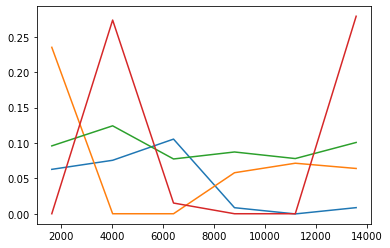

In [33]:
plt.plot(list(zip(*ba_mix))[0], list(zip(*ba_mix))[1])
plt.plot(list(zip(*cl_mix))[0], list(zip(*cl_mix))[1])
plt.plot(list(zip(*ome_mix))[0], list(zip(*ome_mix))[1])
plt.plot(list(zip(*nme2_mix))[0], list(zip(*nme2_mix))[1])
plt.show